<a href="https://colab.research.google.com/github/Enigmatik100/qlearning_project/blob/master/Projet_IA_et_Robotique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rapport du projet de IA et Robotique

<u>**Enoncé** </u>: 
 Algorithme Q-Learning

Dans l'algorithme de Q-learning, on représente la connaissance de l'agent par une fonction. $Q ( s, a )$
a une valeur pour tout couple état-action. Elle peut-être initialisé aléatoirement.
A chaque instant $t$ l'agent successivement :
1. en fonction de son état $s_t$ et de sa connaissance $Q_ t ( s, a_i ) - a_i$ parcourant l'ensemble des actions
possible,  choisit une action $a_t$ et l'exécute. Cette action est choisie au hasard dans un cas de
probabilité $ϵ$ , et sinon est celle qui maximise la fonction $Q$.
2. reçoit de l'environnement la mise à jour de son état $s_{t + 1}$ et la récompense $r_t$ ,

3. met à jour sa connaissance en appliquant la formule suivante

\begin{align}
Q_{t + 1} ( s_t , a_t ) = ( 1 - α) Q_t ( s_t , a_t ) + α ( r_t + λ \times max_i Q_t ( s_{t + 1} , a_i )) 
\end{align}

dans laquelle $α$ est un coefficient
compris entre 0 et 1 qui détermine le poids de la nouvelle connaissance par rapport au poids de
l'expérience, et $λ$ est un coefficient compris entre 0 et 1 qui précise l'importance des gains à venir
par rapport aux gains futurs.

## Environnement

*   En jaune c'est la destination de l'agent
*   En rouge c'est la position initial de l'agent
*   En blanc c'est l'espace ou l'agent peut se déplacer sans être pénalisé

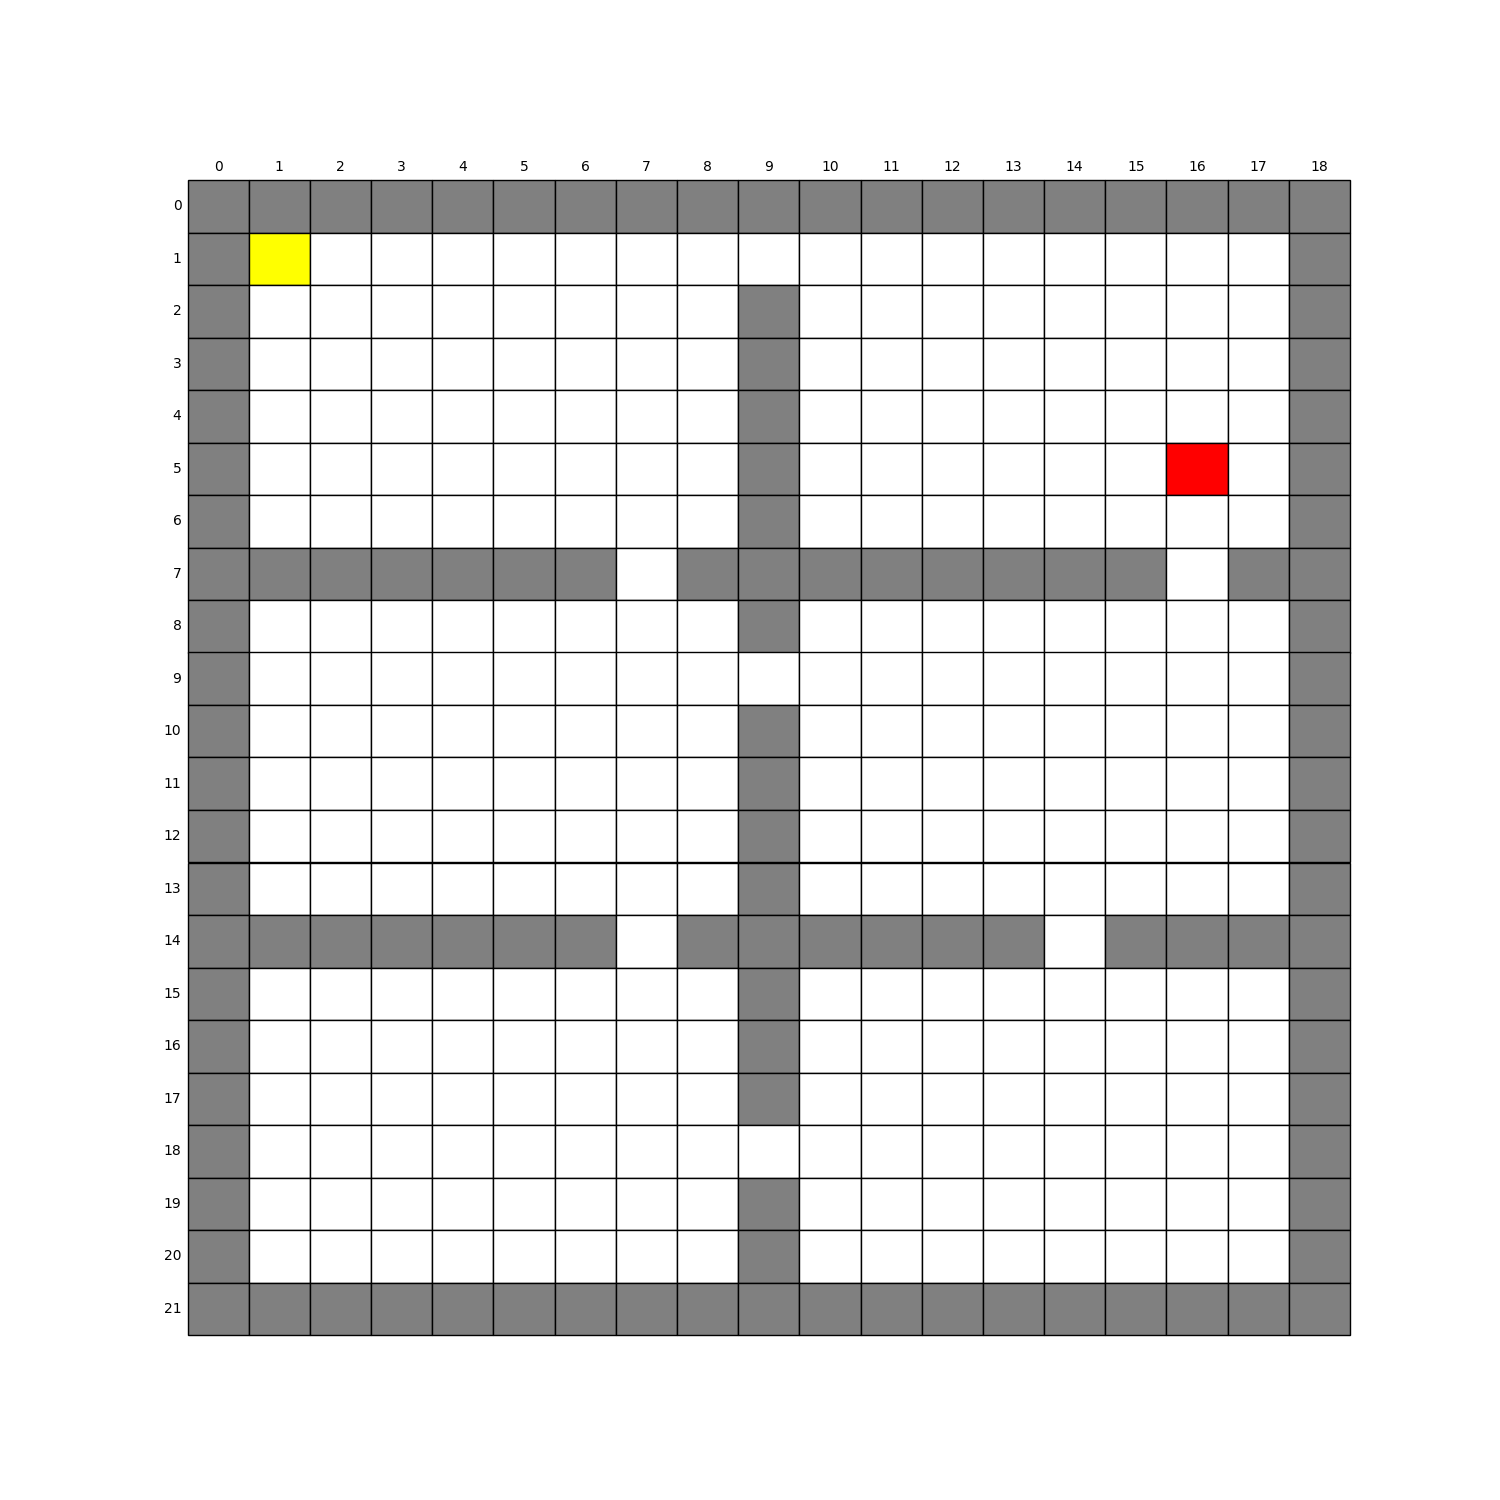

## Environnement  avec les récompenses



*   En jaune c'est la destination de l'agent avec une récompense de $10$
*   En rouge c'est la position initiale de l'agent avec une récompense de $-1$.
*   En blanc c'est l'espace ou l'agent peut se déplacer sans être pénalisé avec une récompense $0$.




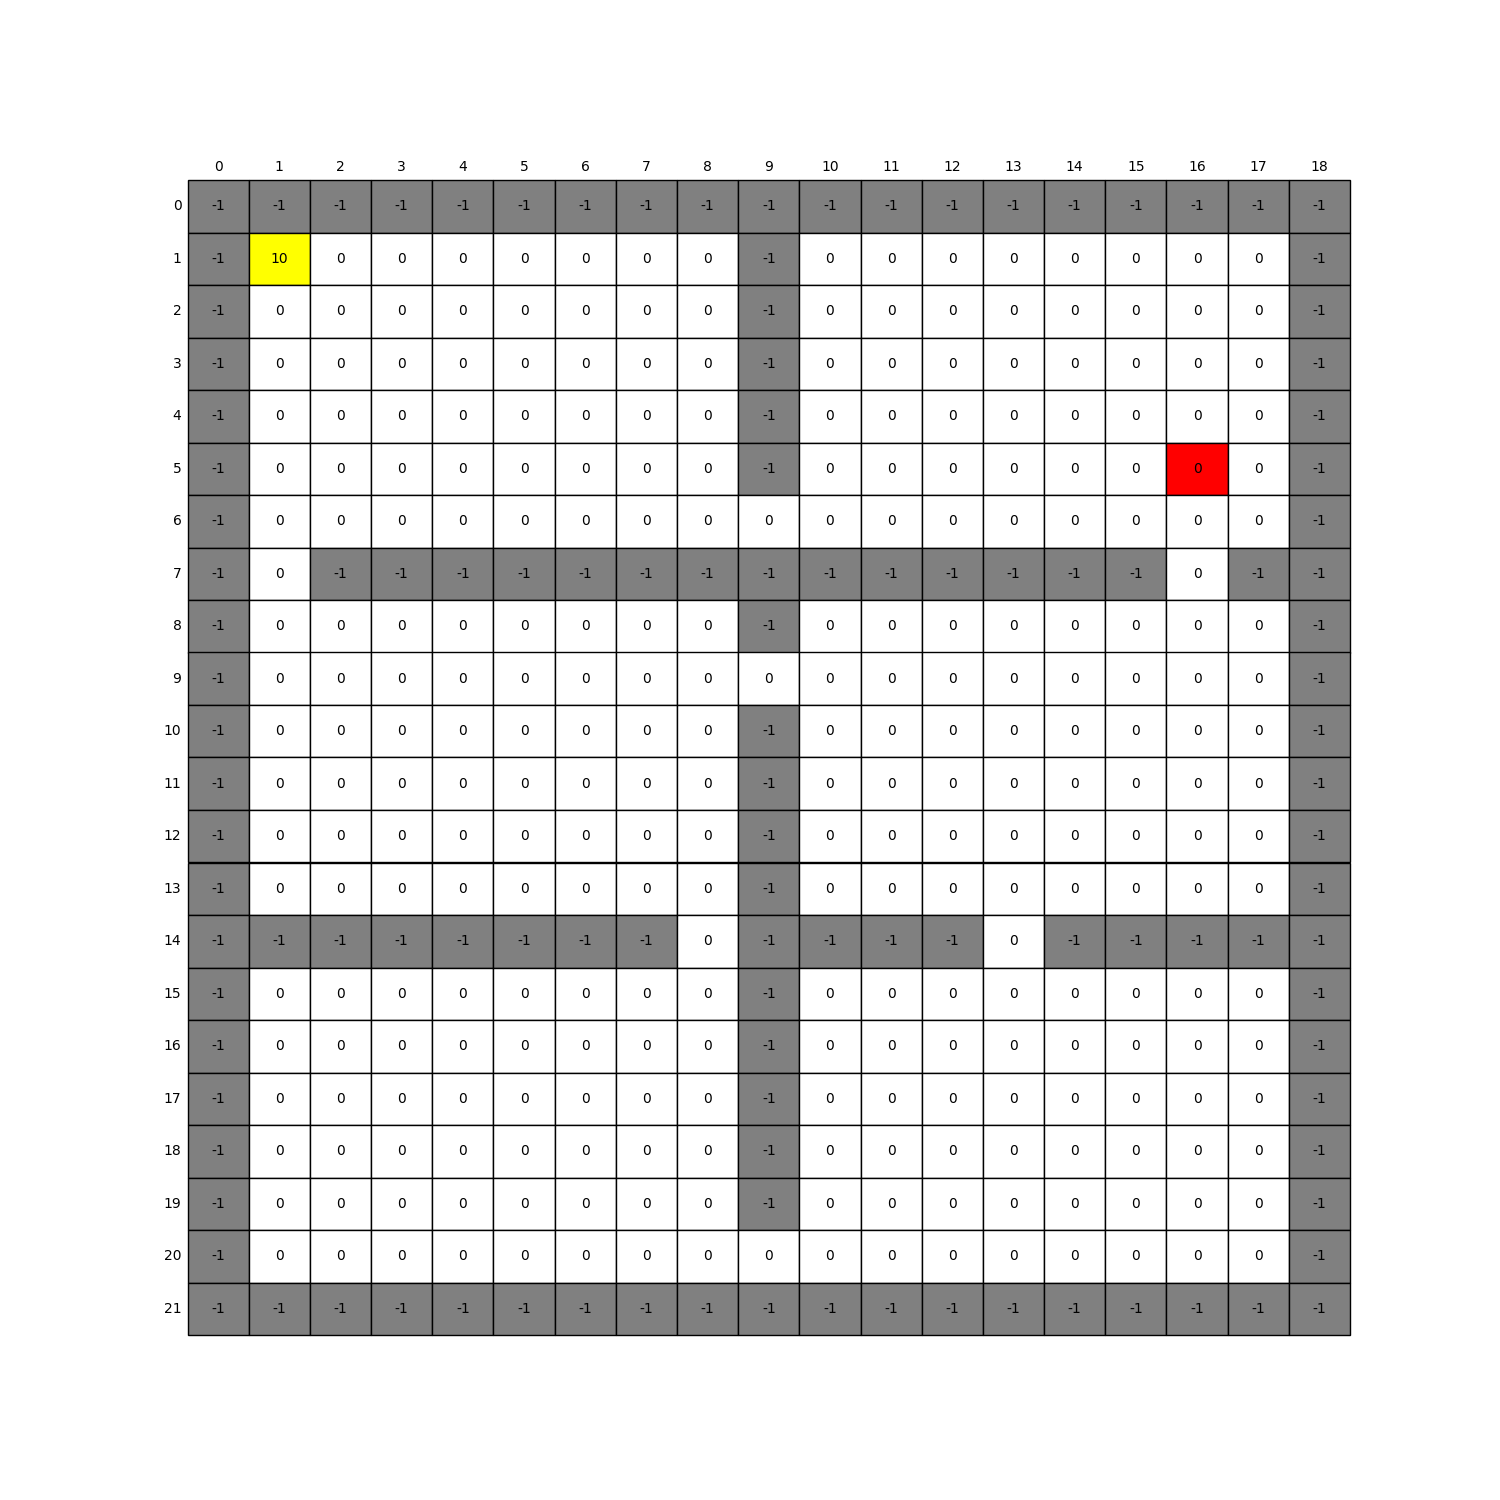

## Code

In [9]:
from re import A
import random

import numpy as np


# les actions possibles
actions = ['Right', 'Left', 'Up', 'Down']


def print_env(m):
    shape = m.shape
    d = {-1: '#', 0: '*', 10: 'G'}

    for i in range(shape[0]):
        for j in range(shape[1]):
            print(f' {d[m[i][j]]} ', end='')
        print('')


class Env:
    def __init__(self, shape=(22, 19)):
        self.shape = shape
        self.rewards = self.generate_env()


    # permet de créer l'environnement
    def generate_env(self):
        m = np.zeros(self.shape, dtype=np.int32)
        h_sep = []
        v_sep = []
        m[1][1] = 10
        for i in range(0, self.shape[0], int((self.shape[0] - 1) / 3)):
            v_sep.append(i)
            m[i][:] = -1

        for i in range(0, self.shape[1], int((self.shape[1] - 1) / 2)):
            h_sep.append(i)
            m[:, i] = -1

        for i in range(1, len(v_sep) - 1):
            for j in range(len(h_sep) - 1):
                r = random.randint(h_sep[j] + 1, h_sep[j + 1] - 1)
                coord = (v_sep[i], r)
                m[coord] = 0

        for i in range(1, len(h_sep) - 1):
            for j in range(len(v_sep) - 1):
                r = random.randint(v_sep[j] + 1, v_sep[j + 1] - 1)
                coord = (r, h_sep[i])
                m[coord] = 0
        print(m)
        return m
    
    # retourne true s'il s'agit d'un mur ou de la destination finale
    def is_wall_or_destination(self, curr_row_index, curr_col_index):
      if self.rewards[curr_row_index, curr_col_index] == 0:
        return False
      else:
        return True


class Agent:
    def __init__(self, env):
        self.env = env
        self.pos = self.get_initial_position()
        # un tenseur 4 D pour representer les connaissances de l'agent
        # nous avons arrondi à deux chiffres après la virgule les valeurs générées
        self.knowledge = np.around(np.random.rand( self.env.shape[0], self.env.shape[1], 4), 2)



    def get_initial_position(self):
        # Générer une position aléatoire 
        pos = (random.randint(1, self.env.shape[0] - 1), random.randint(1, self.env.shape[1] - 1))

        # tant que la position générée n'est pas dans l'environnement et n'est pas une cellule terminale
        # on génère une nouvelle autre position
        while 0 > pos[0] > self.env.shape[0] and 0 > pos[1] > self.env.shape[1] \
                and self.env.is_wall_or_destination(*pos):
            pos = (random.randint(1, self.env.shape[0] - 1), random.randint(1, self.env.shape[1] - 1))
        return pos

    def find_next_action(self, curr_row_index, curr_col_index, epsilon):
        if np.random.random() < epsilon:
            # choisir l'action la plus prometteuse d'apprès la table de connaisance pour cet état
            arg_max =  np.argmax(self.knowledge[curr_col_index, curr_col_index])
            return actions[arg_max]
        else: 
            # choisir une action aléatoire
            return np.random.choice(actions)



    def find_next_position(self, x, y, action):

        # definite less coordonnées des cellules suivantes en fonction de l'action choisie et de la position actuelle
        moves = {"Right": (x, y + 1), "Left": (x, y - 1), "Up": (x - 1, y), "Down": (x + 1, y)}

        if action == 'Up' and x > 0:
            return moves['Up']
        elif action == 'Right' and y < self.env.shape[1] - 1:
            return moves[action]
        elif action == 'Down' and x < self.env.shape[1] - 1:
            return moves['Down']
        elif action == "Left" and x > 0:
            return moves['Left']
        else:
            return (x,y)
  
    def find_path(self, start_x, start_y):
        path_to_destination = []
        if self.env.is_wall_or_destination(start_x, start_y):
            return path_to_destination
        else:
            curr_row_index, curr_col_index = start_x, start_y

            path_to_destination.append([curr_row_index, curr_col_index])

            while not self.env.is_wall_or_destination(curr_row_index, curr_col_index):
            # choisir la meilleure action à prendre raison pour laquelle epsilon vaut 1
                action = self.find_next_action(curr_row_index, curr_col_index, 1.)
                action_index = actions.index(action)
                # se déplacer à cette nouvelle position 

                curr_row_index, curr_col_index = self.find_next_position(curr_row_index, curr_col_index, action)
                path_to_destination.append([curr_row_index, curr_col_index])
            return path_to_destination


    def run(self, MAX_ITER, MAX_MOVEMENT=50, epsilon=0.9, _alpha=0.9, _lambda=0.9):
        """
        epsilon: le pourcentage de fois où il faut prendre le meilleur action au lieu d'une action aléatoire
        _alpha: le taux d'apprentissage de l'agent
        _lambda: facteur de dimunition de la prochaine récompense
        """
        for iter in range(MAX_ITER):
          curr_row_index, curr_col_index = self.get_initial_position()
          print(f"Iterations = {iter} sur {MAX_ITER}")

          # continuer de prendre des actions tant qu'on ne rencontre pas un mur

          count_movement = 0
          while not self.env.is_wall_or_destination(curr_row_index, curr_col_index) and count_movement <  MAX_MOVEMENT:
                
                # choisir quelle action prendre( où aller)
                action = self.find_next_action(curr_row_index, curr_col_index, epsilon)
                action_index = actions.index(action) # get action index

                # réaliser une action et une transition vers le prochain état (se déplacer vers la prochaine destination)
                prec_row_index, prec_col_index = curr_row_index, curr_col_index
                curr_row_index, curr_col_index = self.find_next_position(curr_row_index, curr_col_index, action)
           
                # mettre à jour les connaissances de l'agent
                # self.knowledge[prec_row_index, prec_col_index, action_index] = (1 - _alpha)*self.knowledge[prec_row_index, prec_col_index, action_index] \
                # + _alpha * (self.env.rewards[curr_row_index,curr_col_index] + _lambda * np.max(self.knowledge[curr_row_index, curr_col_index]))


                # percevoir la récompense de l'action effectuée 
                reward = self.env.rewards[curr_row_index,curr_col_index]
                old_q_value = self.knowledge[prec_row_index, prec_col_index, action_index]

                temporal_diff = reward + (_lambda * np.max(self.knowledge[curr_row_index, curr_col_index])) - old_q_value

                # mettre à jour les connaissances 
                new_q_values = old_q_value + (_alpha * temporal_diff)
                self.knowledge[prec_row_index, prec_col_index, action_index] = new_q_values
                count_movement += 1
        
        print("Entrainement terminé")


In [ ]:
env = Env()
agent = Agent(env)
print("start location = ", agent.pos)
MAX_ITER = 10**5
print("----------rewards-----------")
print(env.rewards)
print("----------knoweldge ----------")
print(agent.knowledge)
agent.run(MAX_ITER)

In [10]:
print(agent.env.rewards)

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 10  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [-1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0 -1  0  0  0

## Résultats et interprétations

In [11]:

# On donne une position aléatoire à l'agent, et on voit s'il trouve le chemin pour sa destination
start_pos = (5, 10)
path = agent.find_path(*start_pos)

In [12]:
path

[[5, 10], [4, 10], [3, 10], [2, 10], [1, 10], [0, 10]]

Ce chemin est ensuite utiliser pour simuler son parcourt jusqu'à la destination

In [13]:
# Nous avons réalisé une simulation de l'environnement après l'entrainement

import matplotlib.pyplot as plt
import numpy as np
import pandas

from matplotlib.table import Table
 
def plot_env(path):
    data = pandas.DataFrame(env.rewards, 
                columns=list(range(19)))
    print(len(path))
    for i in range(len(path)):
        checkerboard_table(data, path[i])
        plt.savefig(f'img_{i}.png', 
                transparent = False,  
                facecolor = 'white'
               )
        # plt.show()

def checkerboard_table(data, agent_pos, fmt='{:.2f}', bkg_colors=['gray', 'white', 'yellow', 'red']):
    fig, ax = plt.subplots(1,1, figsize=(15,15))
    ax.set_axis_off()
    tb = Table(ax, bbox=[0,0,1,1])

    nrows, ncols = data.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    # Add cells
    for (i,j), val in np.ndenumerate(data):
        # Index either the first or second item of bkg_colors based on
        # a checker board pattern
        if env.rewards[i][j] == -1:
            color = bkg_colors[0]
        elif env.rewards[i][j] == 10:
           color = bkg_colors[2]
        elif env.rewards[i][j] == 0 and [i,j] == agent_pos:
            color = bkg_colors[3]
        else:
            color = bkg_colors[1] 
        
            

        tb.add_cell(i, j, width, height, text="", 
                    loc='center', facecolor=color)

    # Row Labels...
    for i, label in enumerate(data.index):
        tb.add_cell(i, -1, width, height, text=label, loc='right', 
                    edgecolor='none', facecolor='none')
    # Column Labels...
    for j, label in enumerate(data.columns):
        tb.add_cell(-1, j, width, height/2, text=label, loc='center', 
                           edgecolor='none', facecolor='none')
    ax.add_table(tb)
    return fig



6


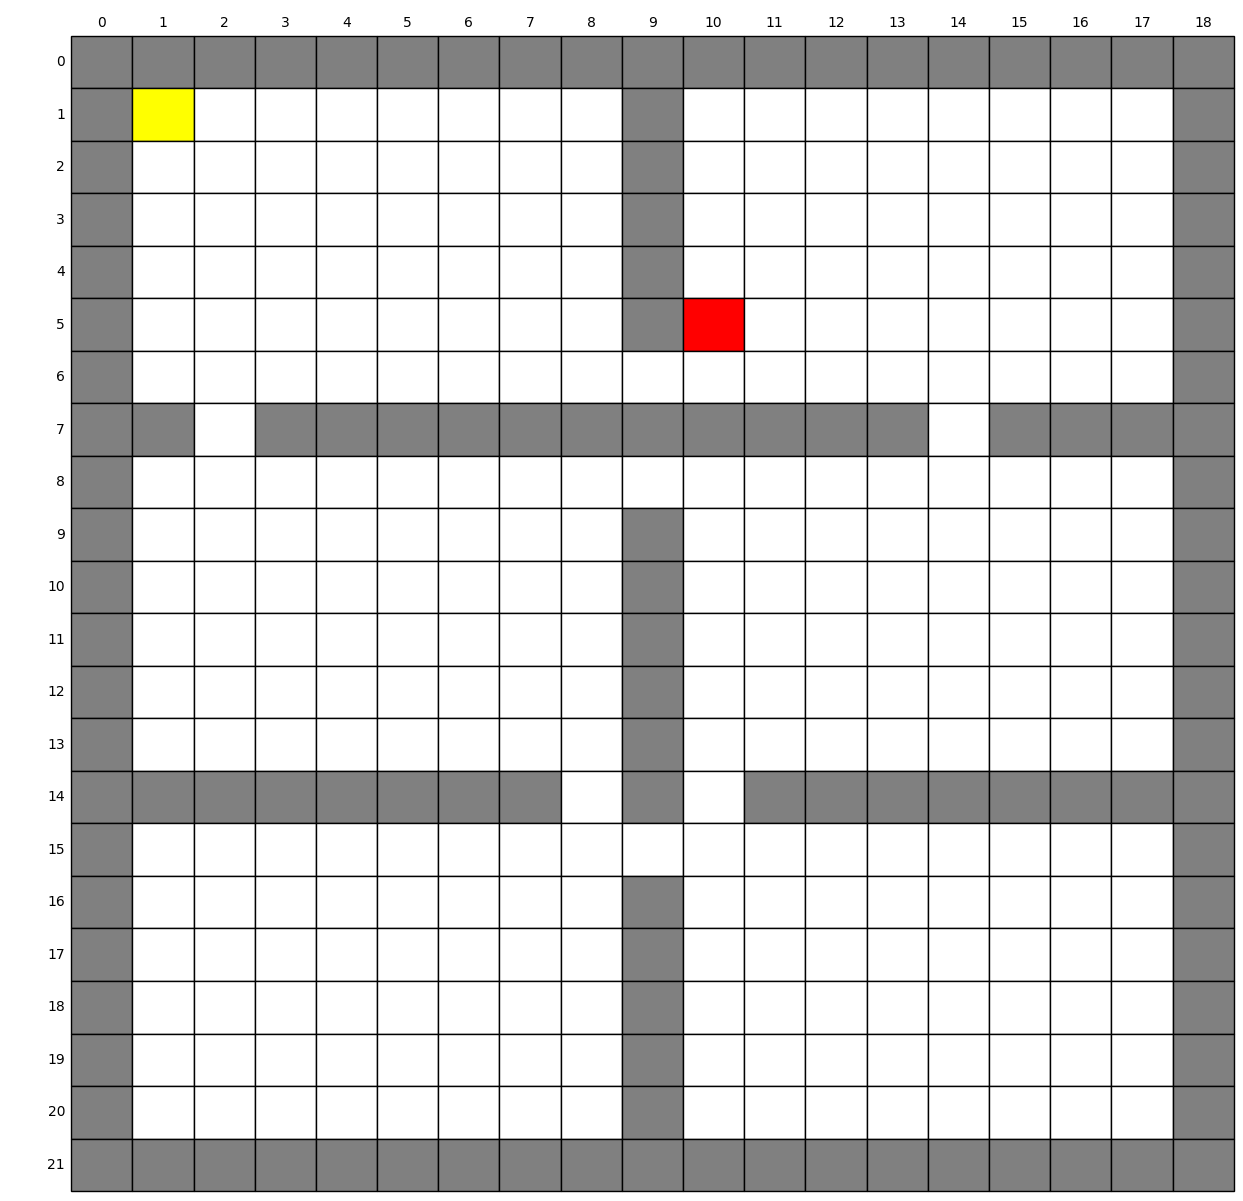

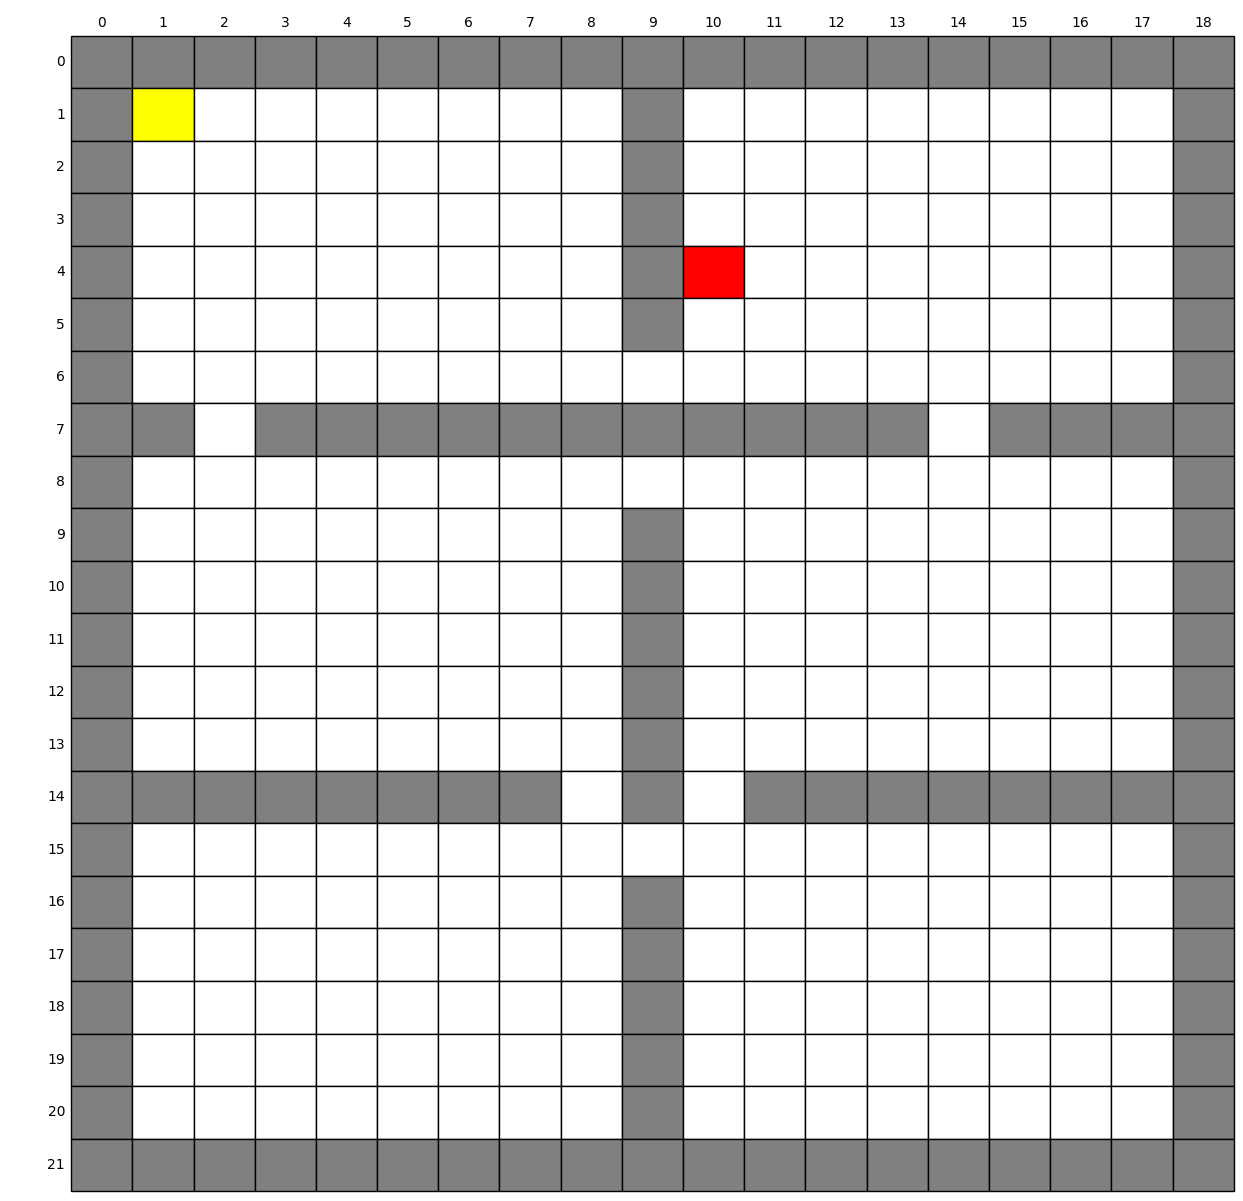

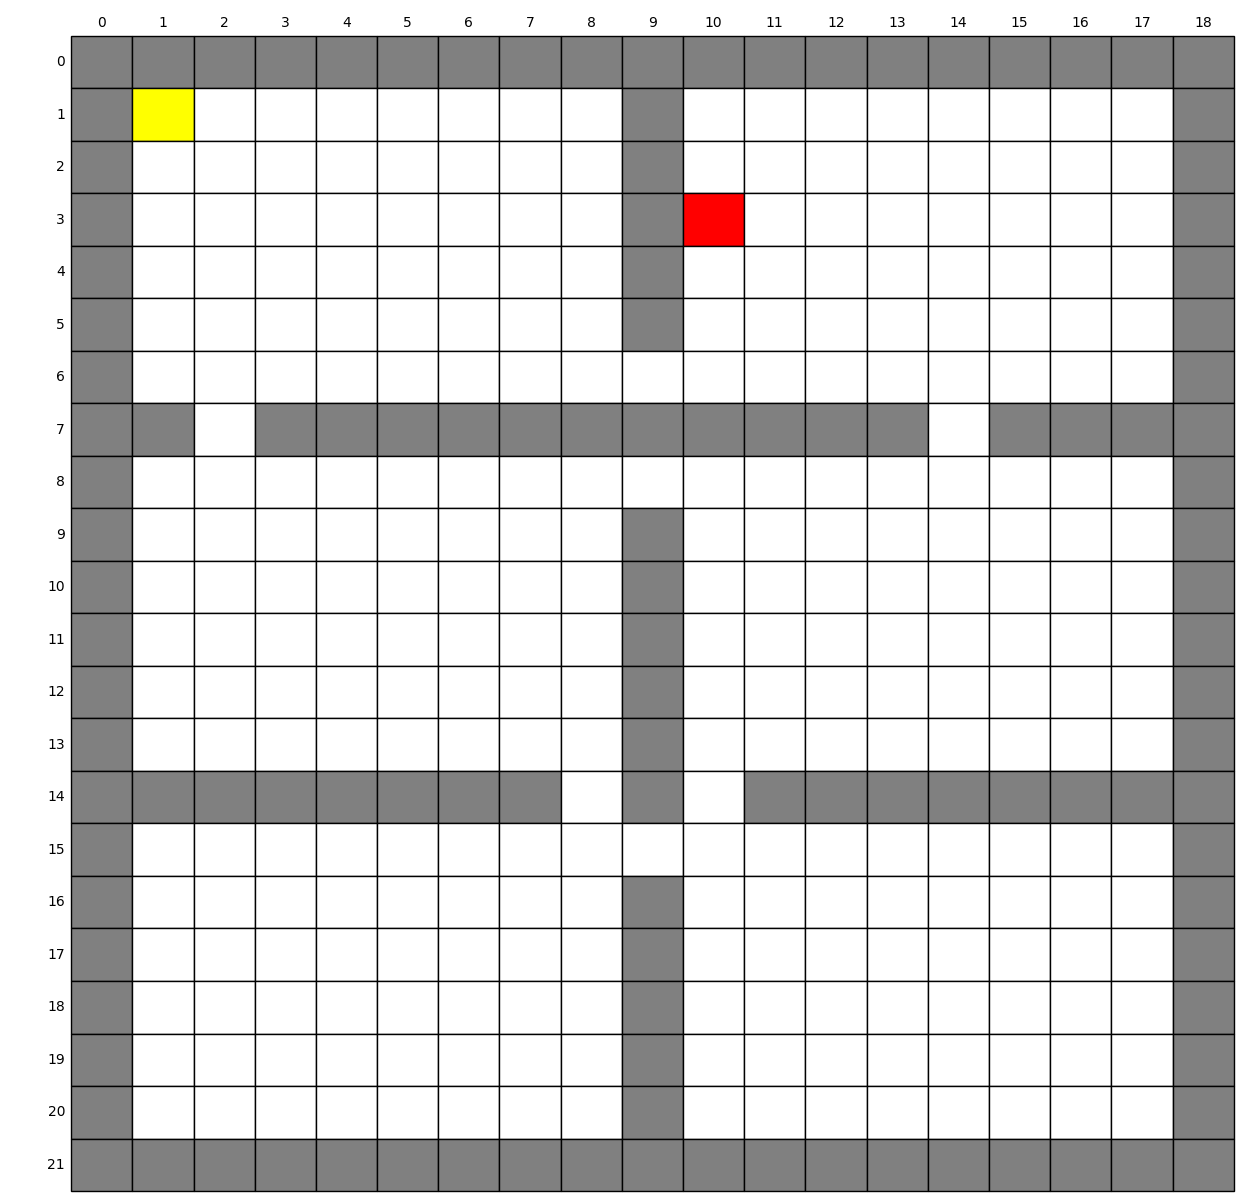

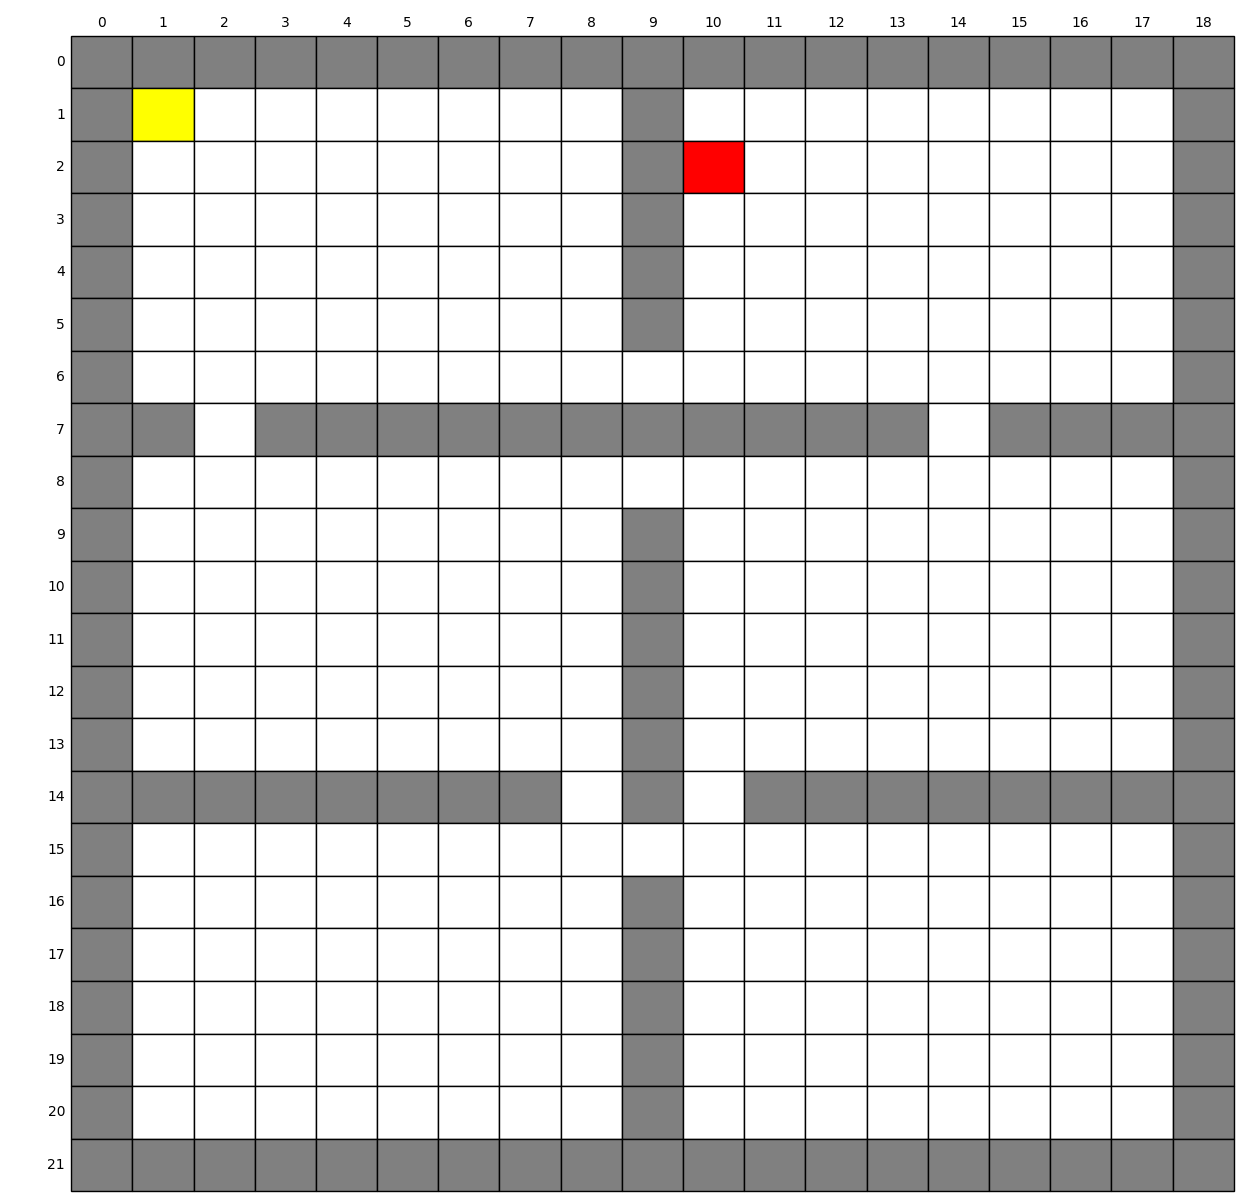

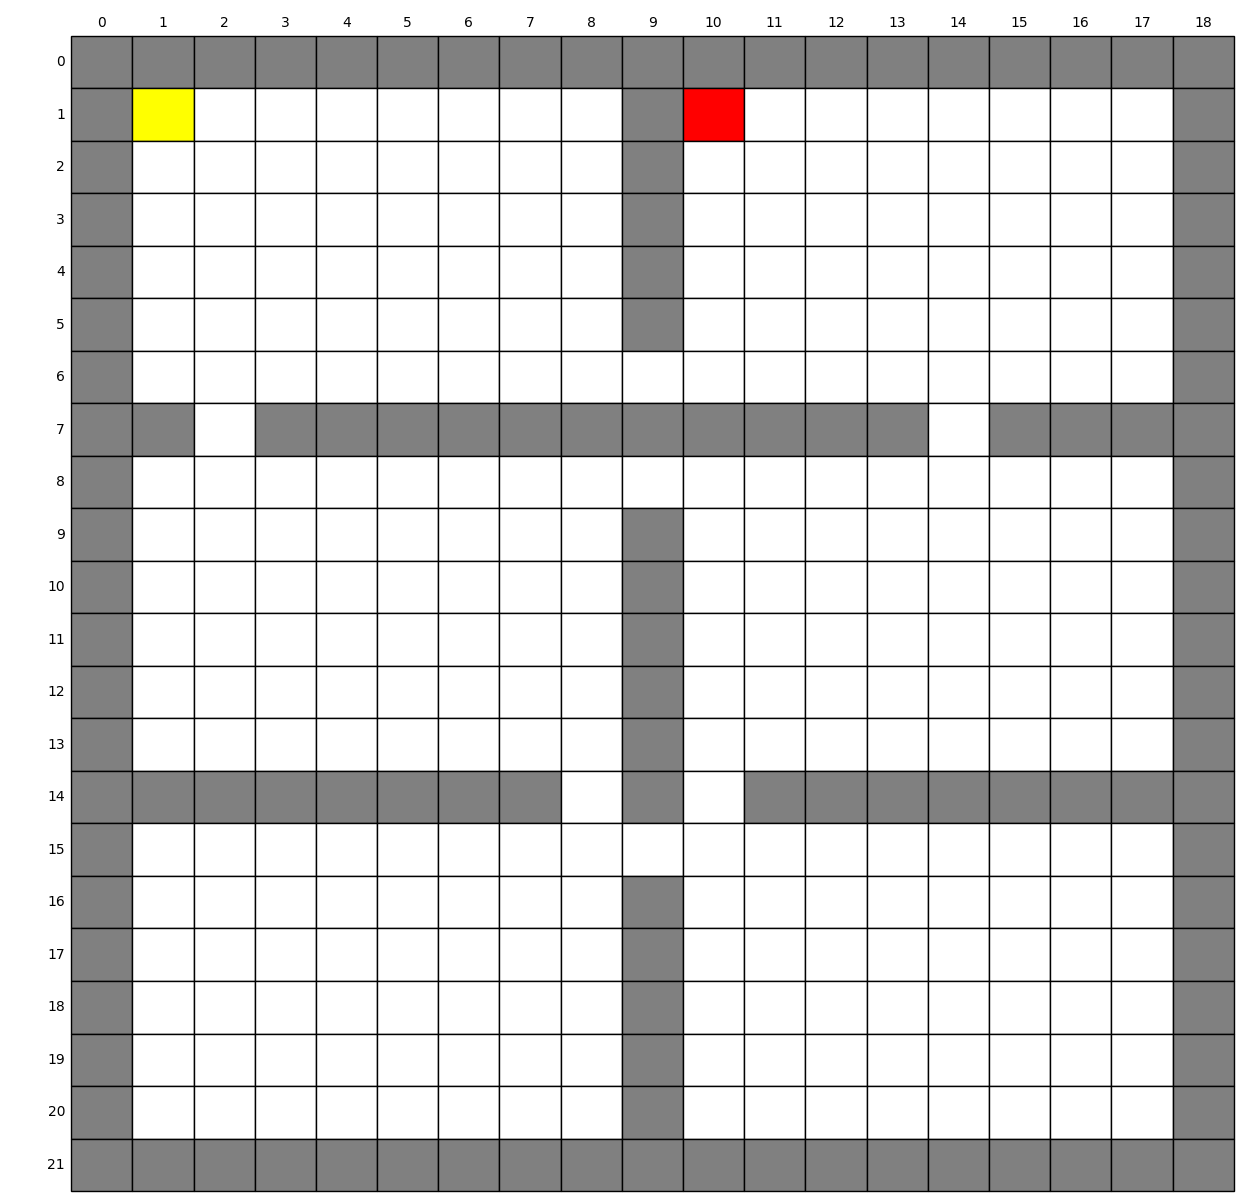

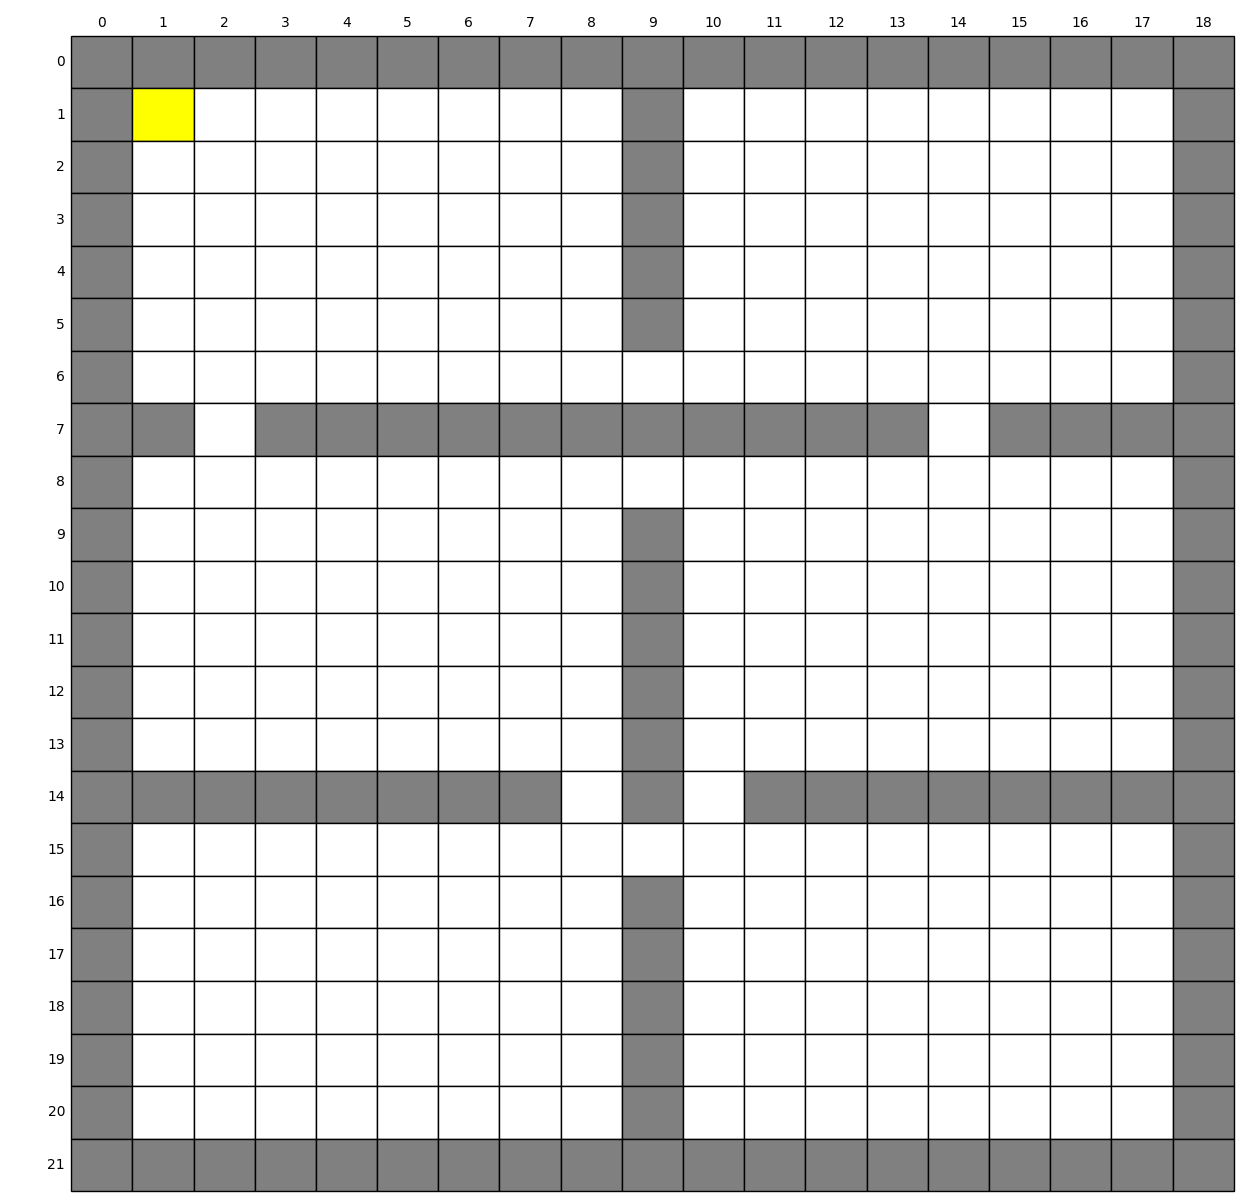

In [14]:
plot_env(path)

In [15]:
import imageio

frames = []
for i in range(len(path)):
    image = imageio.v2.imread(f'img_{i}.png')
    frames.append(image)

In [16]:
imageio.mimsave('example2.gif', # output gif
                frames,          # array of input frames
                fps = 10) 

On remarque que lorsque l'agent se retrouve dans la même salle que la destination, il trouve facilement le chemin pour se rendre à la destination comme l'indique le gif ci-dessous.

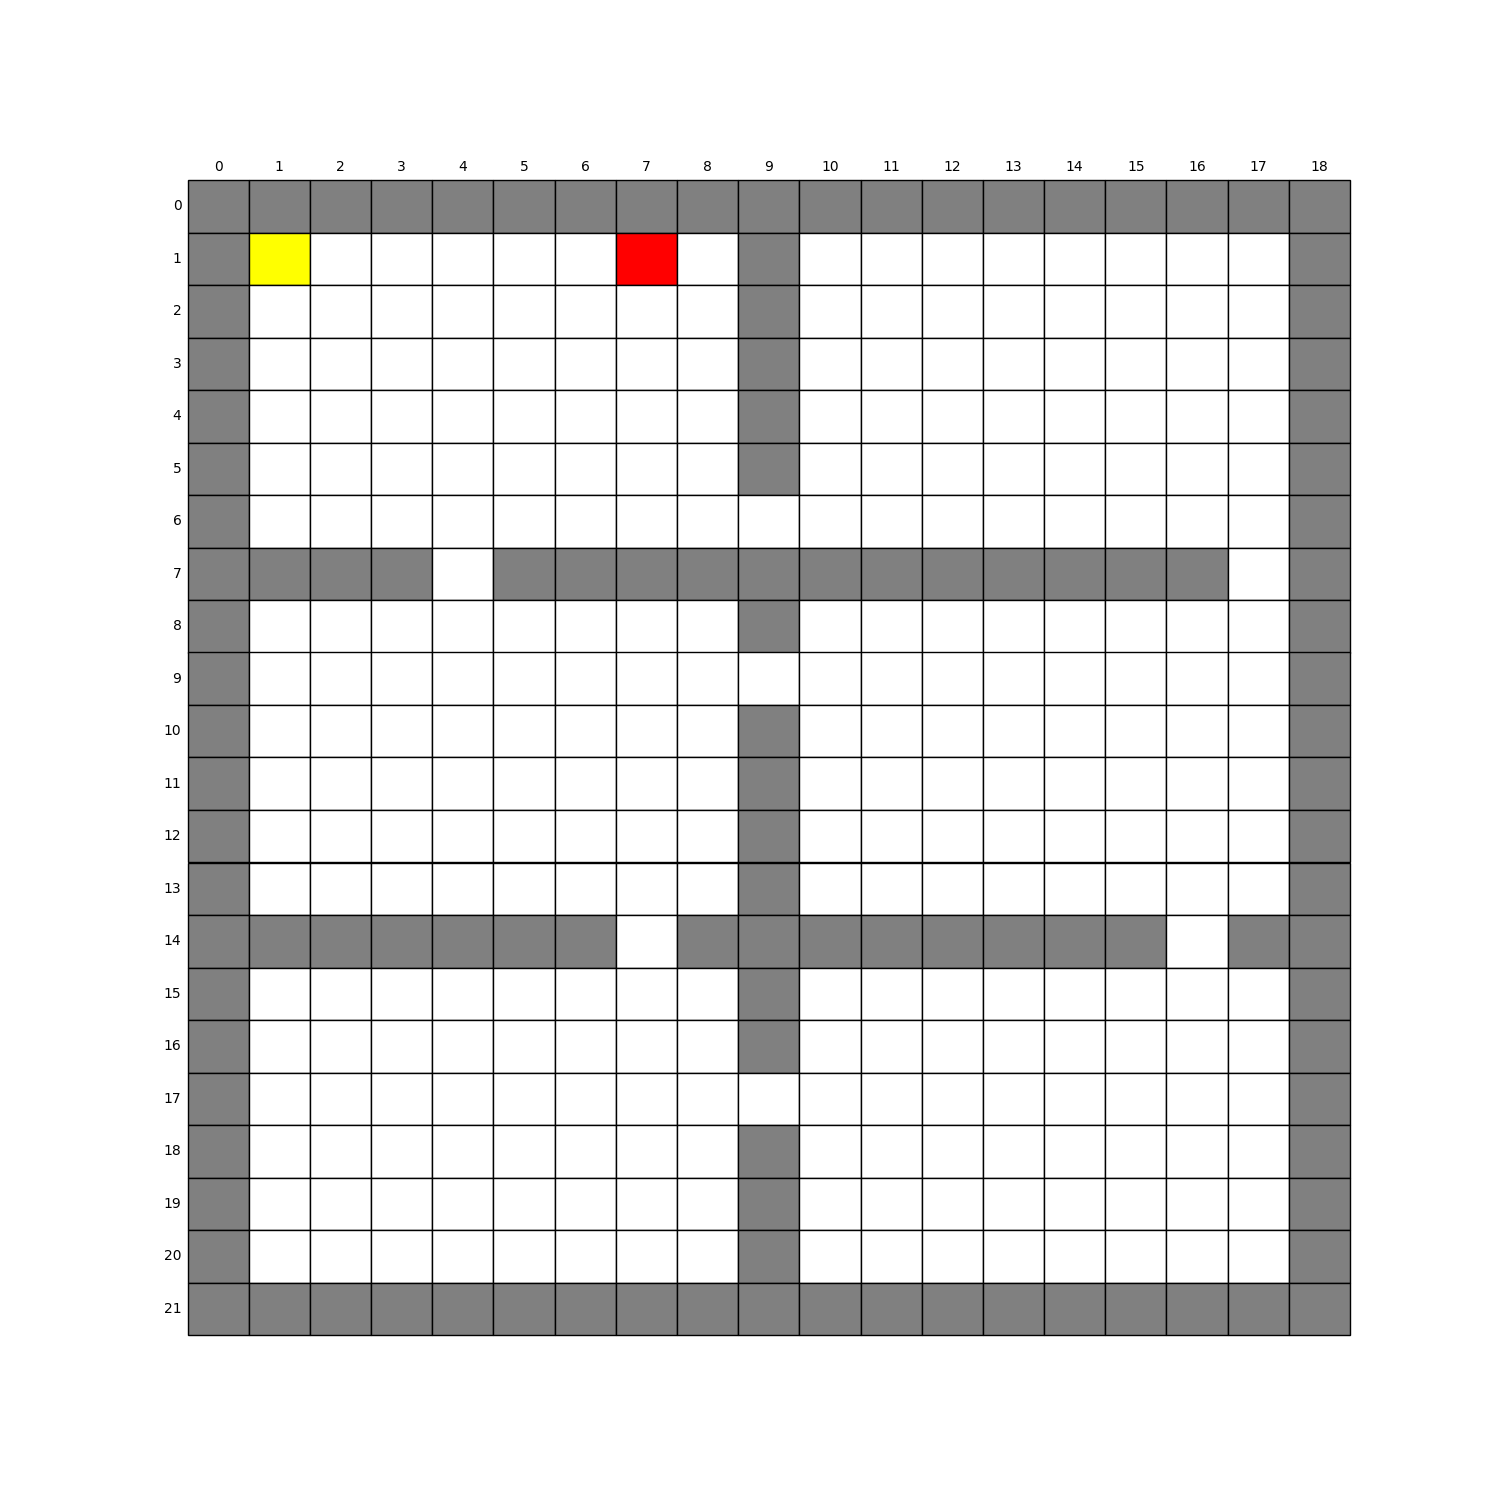

On remarque que lorsque l'agent se retrouve dans une salle différente de la salle dans laquelle se trouve la destination, il éprouve des difficultés à trouver le chemin.

Comme indique la figure ci-dessous

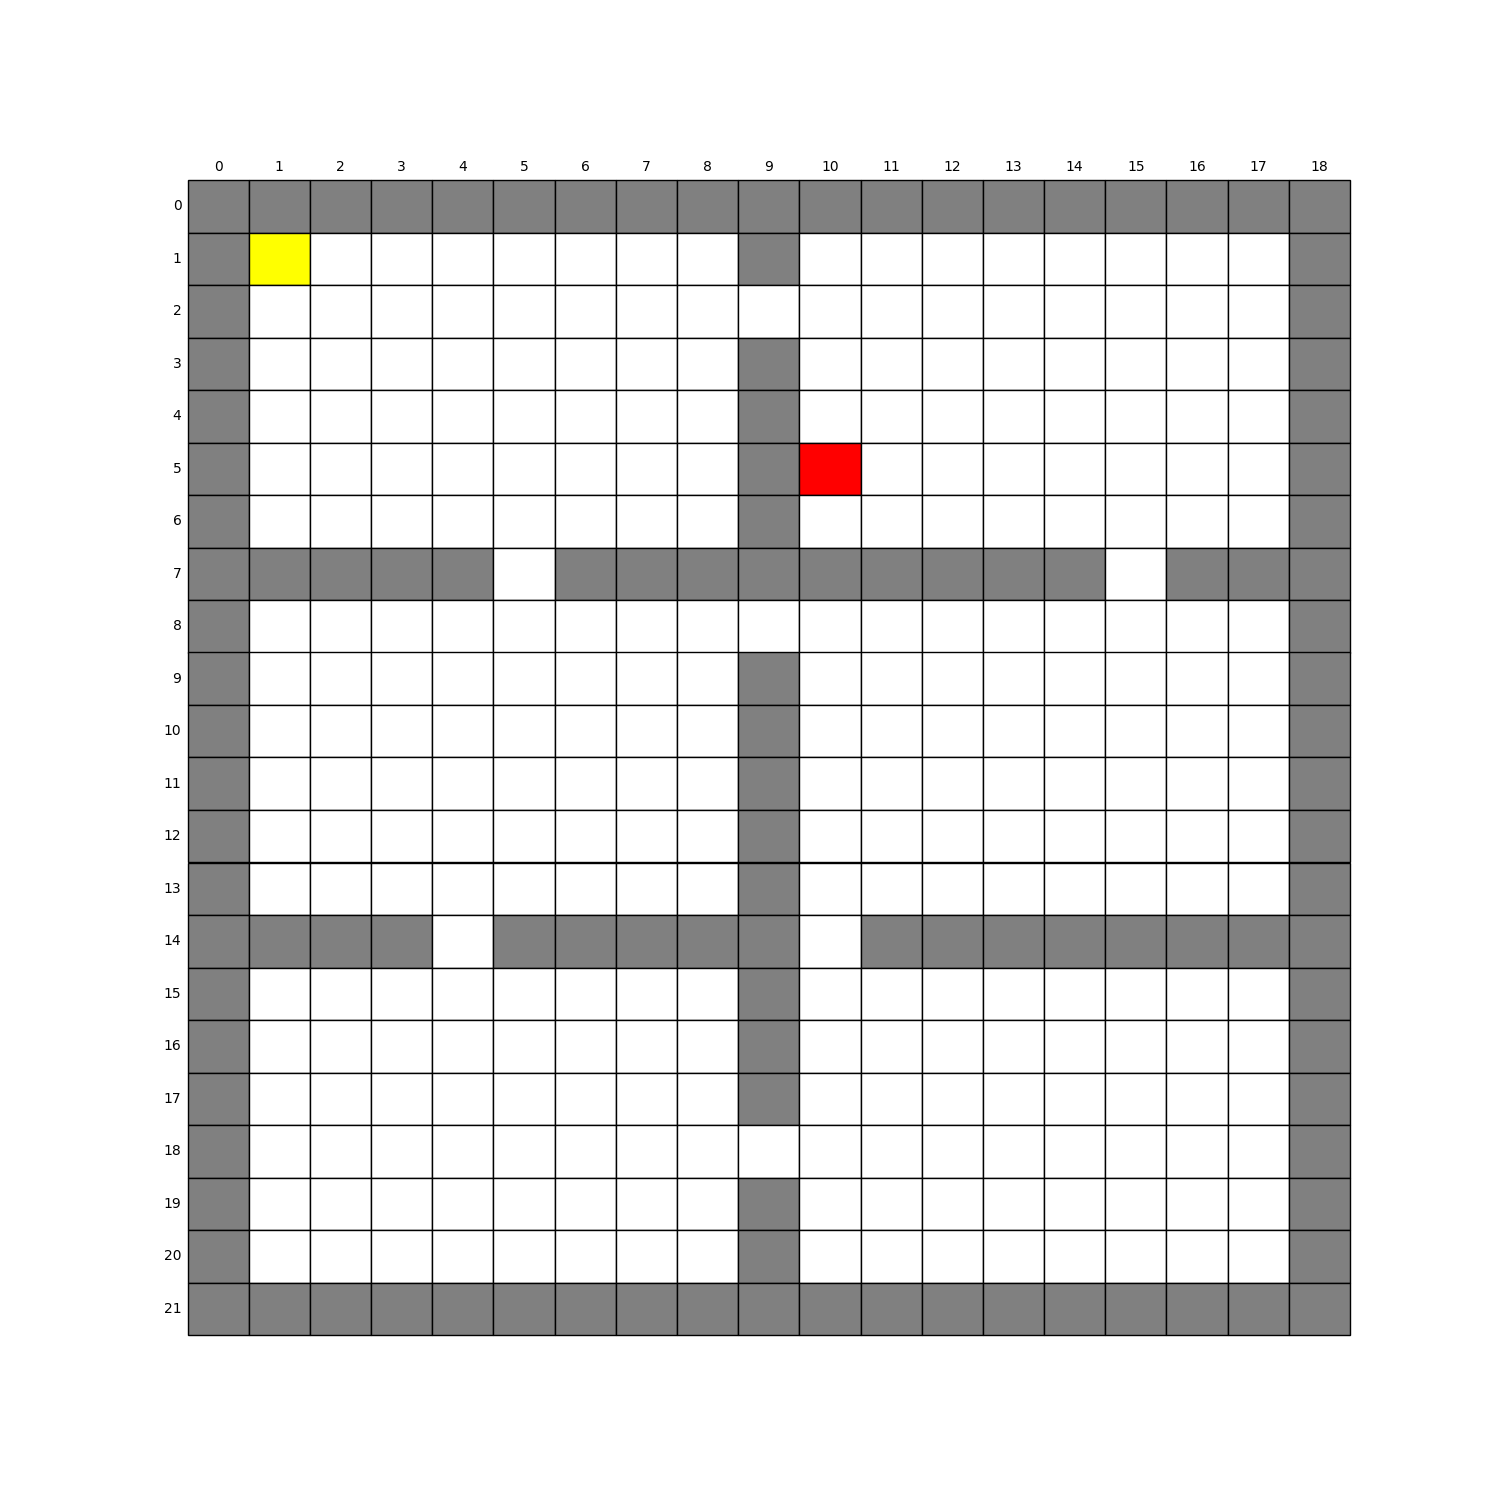

## Conclusion

A l’issu de ce projet nous avons pu implémenter l’algorithme de reinforcement learning Q-learning.
Cela nous a permis d’apprendre à l’agent à retrouver le chemin vers la destination. 
Malgré les quelques fois où l’agent ne retrouve pas le chemin, on a obtenu des résultats assez satisfaisant.
Il faudrait peut être changer les valeurs des récompenses pour voir comment réagirait l’agent dans les cas où il n’a pas pu retrouver son chemin

In [19]:
!cp '/content/drive/MyDrive/Colab Notebooks/Projet_IA_et_Robotique.ipynb' ./
!jupyter nbconvert --to PDF "Projet_IA_et_Robotique.ipynb"

[NbConvertApp] Converting notebook Projet_IA_et_Robotique.ipynb to PDF
[NbConvertApp] Support files will be in Projet_IA_et_Robotique_files/
[NbConvertApp] Making directory ./Projet_IA_et_Robotique_files
[NbConvertApp] Making directory ./Projet_IA_et_Robotique_files
[NbConvertApp] Making directory ./Projet_IA_et_Robotique_files
[NbConvertApp] Making directory ./Projet_IA_et_Robotique_files
[NbConvertApp] Making directory ./Projet_IA_et_Robotique_files
[NbConvertApp] Making directory ./Projet_IA_et_Robotique_files
[NbConvertApp] Writing 56949 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 210618 bytes to Projet_IA_et_Robotique.pdf
